# Replica project

## Creating a topology of artworks from the Cini Foundation Fototeca

### The data

The Cini Foundation possesses 300,000 cardboards containing the photograph of artworks and some metadata. These have been digitized as part of the Replica project and are now available in IIIF format.

The artworks span 12th-20th century, with most artworks being between 1400-1699. The artworks are mostly from Venician artists and most are Italian/European.

In [2]:
# loading the metadata
%load_ext autoreload
%autoreload 2

import pandas as pd
from IPython.display import Image as Image2
import numpy as np

from torch import nn
import torchvision.models as models
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

from urllib.request import urlretrieve 
import pickle
from glob import glob
from scipy import sparse

from torch.utils.data import DataLoader

from utils import *
from dataloader_replica import ReplicaDataset
from train_replica import train_replica
from model_replica import ReplicaNet


In [3]:
path = '/home/guhennec/scratch/2021_Cini/TopologicalAnalysis_Cini/data/'
data_dir = '/scratch/students/schaerf/'
metadata = pd.read_csv(path + 'Cini_20210811.csv', sep=';')
metadata.head(5)

/tmp/ipykernel_3718217/1693302676.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(path + 'Cini_20210811.csv', sep=';')


Drawer ImageNumber               Author  \
0     1A           1  ALLEGRINI Francesco   
1     1A           2     BAROCCI Federico   
2     1A           3      BASSANO Leandro   
3     1A           4     CAMPIGLI Massimo   
4     1A           5      CARRACCI A attr   

                                         Description        AuthorOriginal  \
0            tca con penna acquarellata 148 x 203 mm  ALLEGRINI, Francesco   
1  Studio di figura penna acquarellata (carboncin...     BAROCCI, Federico   
2              Scene penna su carta blu 171 x 219 mm      BASSANO, Leandro   
3  Ragazza su una scala gessetto su carta bruna g...     CAMPIGLI, Massimo   
4                 Madonna e Santi penna 291 x 205 mm    CARRACCI, A. attr.   

        AuthorULANLabel      AuthorULAN  \
0  Allegrini, Francesco  ulan:500115272   
1     Barocci, Federico  ulan:500115210   
2      Bassano, Leandro  ulan:500015945   
3     Campigli, Massimo  ulan:500029770   
4                   NaN             NaN   

                                    AuthorURL  AuthorComplemented  \
0  http://vocab.getty.edu/page/ulan/500115272                   0   
1  http://vocab.getty.edu/page/ulan/500115210                   0   
2  http://vocab.getty.edu/page/ulan/500015945                   0   
3  http://vocab.getty.edu/page/ulan/500029770                   0   
4                                         NaN                   1   

  AuthorComplement  ...  AuthorDeath AuthorBirthLong AuthorBirthLat  \
0    No complement  ...       1690.0             NaN            NaN   
1    No complement  ...       1612.0       12.633333      43.716667   
2    No complement  ...       1622.0       11.733333      45.766667   
3    No complement  ...       1971.0       13.400000      52.516667   
4             attr  ...          NaN             NaN            NaN   

  AuthorDeathLong AuthorDeathLat     AuthorBirthCity AuthorDeathCity  \
0             NaN            NaN                 NaN             NaN   
1       12.633333      43.716667              Urbino          Urbino   
2       12.326667      45.438611  Bassano del Grappa          Venice   
3        6.639811      43.269316              Berlin             Var   
4             NaN            NaN                 NaN             NaN   

                                uid  \
0  253993c139284a45be233a13121ddeeb   
1  1323356994c24635a11fdcd9d5f9284a   
2  a4268385f6384e61a3dd092bc6b8c083   
3  550f368cdb4442aab4d5e2ada702d6ad   
4  6047de5547b643cb87491be925748bee   

                                        CardboardURL  \
0  https://dhlabsrv4.epfl.ch/iiif_cini/1A%2F1A_1....   
1  https://dhlabsrv4.epfl.ch/iiif_cini/1A%2F1A_2....   
2  https://dhlabsrv4.epfl.ch/iiif_cini/1A%2F1A_3....   
3  https://dhlabsrv4.epfl.ch/iiif_cini/1A%2F1A_4....   
4  https://dhlabsrv4.epfl.ch/iiif_cini/1A%2F1A_5....   

                                            ImageURL  
0  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...  
1  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...  
2  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...  
3  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...  
4  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...  

[5 rows x 37 columns]

In [3]:
metadata['uid'].nunique(), metadata.shape

(329480, (330002, 37))

In [4]:
# dropping duplicates

metadata = metadata.groupby('uid').first().reset_index()

In [5]:
# taking, for example, a subset of the data
titian_data = metadata[metadata['AuthorOriginal'].fillna('').str.startswith('TIZIANO')]
titian_data.shape

(2265, 37)

The image url allows to retrieve the image from the IIIF source.

In [6]:
example_url = titian_data.reset_index()['ImageURL'][0]

print(example_url)
display(Image2(url=example_url, width=200, height=200))

https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F1C%2F1C_484.jpg/full/full/0/default.jpg


#### Data loader for model?

### The morphograph

The morphograph is an annotated graph containing sets of two images that are considered similar according to the definition that they share a similar visual or physical trait. Where is this set stored? 

#### Data loader for this set?

In [4]:
# in jeanne's code
with open(path + 'save_link_data_2018_08_02.pkl', 'rb') as f:
    morpho_graph_complete = pickle.load(f)

# contains uid	img1	img2	type	annotated
morpho_graph_complete.head()

uid                              img1  \
0  0f84770be893475581bebd8c0ce95704  4b6e5a18012e4974a43f6f652c9cad78   
1  5ade49fc2dc649b9947496a41e2decdb  384b9f017d5f43ba9dcfd92f2af830c4   
2  bf4d99eaf7da4bd486f9007c90c177a5  94fe74bcebf9442fb5cd9a0327590a84   
3  b29ec3c83c5641f9b6afadb2409b6746  922fe92d61e744b1a9462c848a916bcf   
4  ab27b55997b94bef9cca122829e9f64d  94fe74bcebf9442fb5cd9a0327590a84   

                               img2      type                        annotated  
0  e3329a91a266412fb1a0975d70894178  POSITIVE 2017-07-19 15:02:50.997512+00:00  
1  e3329a91a266412fb1a0975d70894178  POSITIVE 2017-07-19 15:02:51.238615+00:00  
2  726f47fb5bd94c5db8069334cc58020e  POSITIVE 2017-07-20 12:18:23.705228+00:00  
3  726f47fb5bd94c5db8069334cc58020e  POSITIVE 2017-07-20 12:18:24.021703+00:00  
4  922fe92d61e744b1a9462c848a916bcf  POSITIVE 2017-07-20 12:18:23.873097+00:00

In [5]:
morpho_graph_complete['type'].value_counts() # does positive mean similar?

DUPLICATE        114283
POSITIVE           6293
NON-DUPLICATE        60
PROPOSAL             27
Name: type, dtype: int64

In [6]:
morpho_graph_complete['uid'].nunique(), morpho_graph_complete.shape

(120663, (120663, 5))

In [7]:
positives = get_train_test_split(metadata, morpho_graph_complete)

In [8]:
positives.head()

index Drawer ImageNumber            Author  \
0      0     1A         414    DEL VAGA Perin   
1      1     1A         414    DEL VAGA Perin   
2      2     1A         414    DEL VAGA Perin   
3      3     1A         473  RAFFAELLO Sanzio   
4      4     2A         390  MICHELANGELO ua)   

                                         Description     AuthorOriginal  \
0  Il Padre eterno ordina a Giacobbe di tornare a...    PIERIN DEL VAGA   
1  Il Padre eterno ordina a Giacobbe di tornare a...    PIERIN DEL VAGA   
2  Il Padre eterno ordina a Giacobbe di tornare a...    PIERIN DEL VAGA   
3             Studio per la strage degli innocenti..          RAFEAELLO   
4                                      Adamo 265x370  MICHELANGELO ua).   

   AuthorULANLabel      AuthorULAN  \
0  Perino del Vaga  ulan:500000030   
1  Perino del Vaga  ulan:500000030   
2  Perino del Vaga  ulan:500000030   
3          Raphael  ulan:500023578   
4              NaN             NaN   

                                    AuthorURL  AuthorComplemented  ...  \
0  http://vocab.getty.edu/page/ulan/500000030                   0  ...   
1  http://vocab.getty.edu/page/ulan/500000030                   0  ...   
2  http://vocab.getty.edu/page/ulan/500000030                   0  ...   
3  http://vocab.getty.edu/page/ulan/500023578                   0  ...   
4                                         NaN                   0  ...   

                                uid  \
0  ba184597de3b49ad981dd670e3f4fdc3   
1  ba184597de3b49ad981dd670e3f4fdc3   
2  ba184597de3b49ad981dd670e3f4fdc3   
3  4ea3d3c7d09a4576b94de1b0b3b7367d   
4  080e5fad7e424921906064af8858ff61   

                                        CardboardURL  \
0  https://dhlabsrv4.epfl.ch/iiif_cini/1A%2F1A_41...   
1  https://dhlabsrv4.epfl.ch/iiif_cini/1A%2F1A_41...   
2  https://dhlabsrv4.epfl.ch/iiif_cini/1A%2F1A_41...   
3  https://dhlabsrv4.epfl.ch/iiif_cini/1A%2F1A_47...   
4  https://dhlabsrv4.epfl.ch/iiif_cini/2A%2F2A_39...   

                                            ImageURL  \
0  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...   
1  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...   
2  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...   
3  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...   
4  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...   

                     uid_connection                              img1  \
0  bdfa4842d1874800b000bea1cab6c945  ba184597de3b49ad981dd670e3f4fdc3   
1  db7687056cc6443c971b6fc15aebceff  ba184597de3b49ad981dd670e3f4fdc3   
2  59f10bb5431b462ea31aaedee678f3d9  ba184597de3b49ad981dd670e3f4fdc3   
3  560cf3f3701f48f88d2cba0fd5b09edb  4ea3d3c7d09a4576b94de1b0b3b7367d   
4  c38237498f594ef78adfece3fec5aff3  080e5fad7e424921906064af8858ff61   

                               img2      type  \
0  739a2d7e8f214a40b1e83158eaf7db01  POSITIVE   
1  3965fccf37ed4cf98357f356578c6903  POSITIVE   
2  3439c90278934df5b26abb13bde0a2e5  POSITIVE   
3  4539c5d78877400bb267fe8aa883b474  POSITIVE   
4  97772cd22d10442fb39e72ff70a7aff3  POSITIVE   

                         annotated cluster    set  
0 2018-07-10 16:09:55.463941+00:00     806  train  
1 2018-07-10 16:09:55.493311+00:00     806  train  
2 2018-07-10 16:09:55.556896+00:00     806  train  
3 2018-07-26 15:18:32.261548+00:00     318   test  
4 2017-09-20 16:40:44.146672+00:00     372   test  

[5 rows x 45 columns]

In [9]:
#for i in range(positives.shape[0]):
#    urlretrieve(positives['ImageURL'][i], '/scratch/students/schaerf/' + positives['set'][i]+'/'+positives['uid'][i]+'.jpg')

In [10]:
items = set(list(positives['img1']) + list(positives['img2']))
items_2 = set([it.split('/')[-1].split('.')[0] for it in glob('/scratch/students/schaerf/train/*.jpg')] + [it.split('/')[-1].split('.')[0] for it in glob('/scratch/students/schaerf/test/*.jpg')])
print(len(list(items)))

diff = items.difference(items_2) # merge to metadata is losing some information
print(len(list(diff)))

intersec = items.intersection(items_2)
print(len(list(intersec)))

positives = positives[~positives['img1'].isin(diff) & ~positives['img2'].isin(diff)]
print(positives.shape)
positives.head()

1806
464
1342
(3386, 45)


index Drawer ImageNumber                    Author  \
0      0     1A         414            DEL VAGA Perin   
1      1     1A         414            DEL VAGA Perin   
2      2     1A         414            DEL VAGA Perin   
5      5     2A         548  ARTISTA VERONESE SEC XVI   
6      6     2A         548  ARTISTA VERONESE SEC XVI   

                                         Description  \
0  Il Padre eterno ordina a Giacobbe di tornare a...   
1  Il Padre eterno ordina a Giacobbe di tornare a...   
2  Il Padre eterno ordina a Giacobbe di tornare a...   
5                                  Pesca miracolosa.   
6                                  Pesca miracolosa.   

              AuthorOriginal  AuthorULANLabel      AuthorULAN  \
0            PIERIN DEL VAGA  Perino del Vaga  ulan:500000030   
1            PIERIN DEL VAGA  Perino del Vaga  ulan:500000030   
2            PIERIN DEL VAGA  Perino del Vaga  ulan:500000030   
5  ARTISTA VERONESE SEC. XVI              NaN             NaN   
6  ARTISTA VERONESE SEC. XVI              NaN             NaN   

                                    AuthorURL  AuthorComplemented  ...  \
0  http://vocab.getty.edu/page/ulan/500000030                   0  ...   
1  http://vocab.getty.edu/page/ulan/500000030                   0  ...   
2  http://vocab.getty.edu/page/ulan/500000030                   0  ...   
5                                         NaN                   0  ...   
6                                         NaN                   0  ...   

                                uid  \
0  ba184597de3b49ad981dd670e3f4fdc3   
1  ba184597de3b49ad981dd670e3f4fdc3   
2  ba184597de3b49ad981dd670e3f4fdc3   
5  66794131f9fc46999897c2584ea1cbf9   
6  66794131f9fc46999897c2584ea1cbf9   

                                        CardboardURL  \
0  https://dhlabsrv4.epfl.ch/iiif_cini/1A%2F1A_41...   
1  https://dhlabsrv4.epfl.ch/iiif_cini/1A%2F1A_41...   
2  https://dhlabsrv4.epfl.ch/iiif_cini/1A%2F1A_41...   
5  https://dhlabsrv4.epfl.ch/iiif_cini/2A%2F2A_54...   
6  https://dhlabsrv4.epfl.ch/iiif_cini/2A%2F2A_54...   

                                            ImageURL  \
0  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...   
1  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...   
2  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...   
5  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...   
6  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...   

                     uid_connection                              img1  \
0  bdfa4842d1874800b000bea1cab6c945  ba184597de3b49ad981dd670e3f4fdc3   
1  db7687056cc6443c971b6fc15aebceff  ba184597de3b49ad981dd670e3f4fdc3   
2  59f10bb5431b462ea31aaedee678f3d9  ba184597de3b49ad981dd670e3f4fdc3   
5  8e2c6da918a647ffbe62c7fc32a697dc  66794131f9fc46999897c2584ea1cbf9   
6  6821b912d2d84f3fbf71783bce69619f  66794131f9fc46999897c2584ea1cbf9   

                               img2      type  \
0  739a2d7e8f214a40b1e83158eaf7db01  POSITIVE   
1  3965fccf37ed4cf98357f356578c6903  POSITIVE   
2  3439c90278934df5b26abb13bde0a2e5  POSITIVE   
5  63a6e94aa7ac468799ea45f0df3134a1  POSITIVE   
6  8b47beb1f1a6438993f3988e880cfa9c  POSITIVE   

                         annotated cluster    set  
0 2018-07-10 16:09:55.463941+00:00     806  train  
1 2018-07-10 16:09:55.493311+00:00     806  train  
2 2018-07-10 16:09:55.556896+00:00     806  train  
5 2018-07-22 20:34:30.325230+00:00     711   test  
6 2018-07-22 20:34:30.352130+00:00     711   test  

[5 rows x 45 columns]

In [11]:
positives.to_csv('/scratch/students/schaerf/data.csv')

theoretically, the morphograph is a graph indicating the order of similarity and representing different connected components which are then used as training validation and test set, where is the original graph? Is this information retained in the above file?

## Getting a subset of the data

In order to select a subset of the data, we would like to vary spatially and temporally, for it to be suitable to the data in the morphograph and to be comprehensive of what we want to study.


In [14]:
#positives.columns

In [15]:
#fig, ax = plt.subplots(1,1, figsize=(10,7))

#positives['AuthorDeathCity'].hist(bins=positives['AuthorDeathCity'].nunique())
#plt.xticks(rotation = 45)
#plt.xlabel("")
#plt.show()

In [16]:
# fig, ax = plt.subplots(1,1, figsize=(10,7))

# positives['BeginDate'].hist(bins=positives['BeginDate'].nunique())
# plt.xticks(rotation = 45)
# plt.xlabel("")
# plt.show()

It seems like paintings between 1550-1650 in Bologna, Ravenna and Parma may be a decent number

In [12]:
subset = positives[positives['BeginDate'] > 1550][positives['BeginDate'] < 1650][positives['AuthorDeathCity'].isin(['Parma', 'Bologna', 'Ravenna', 'Verona', 'Ferrara'])]
subset.shape

/tmp/ipykernel_3718217/3391840827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = positives[positives['BeginDate'] > 1550][positives['BeginDate'] < 1650][positives['AuthorDeathCity'].isin(['Parma', 'Bologna', 'Ravenna', 'Verona', 'Ferrara'])]


(72, 45)

In [13]:
subset_max = metadata[metadata['BeginDate'] > 1550][metadata['BeginDate'] < 1650][metadata['AuthorDeathCity'].isin(['Parma', 'Bologna', 'Ravenna', 'Verona', 'Ferrara'])].reset_index()
subset_max.shape

/tmp/ipykernel_3718217/3952239037.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_max = metadata[metadata['BeginDate'] > 1550][metadata['BeginDate'] < 1650][metadata['AuthorDeathCity'].isin(['Parma', 'Bologna', 'Ravenna', 'Verona', 'Ferrara'])].reset_index()


(3307, 38)

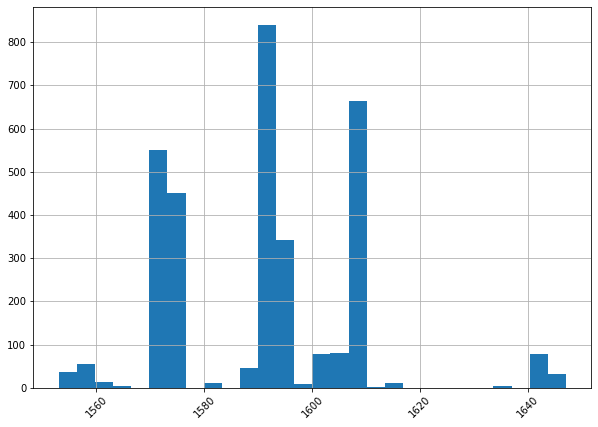

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

subset_max['BeginDate'].hist(bins=subset_max['BeginDate'].nunique())
plt.xticks(rotation = 45)
plt.xlabel("")
plt.show()

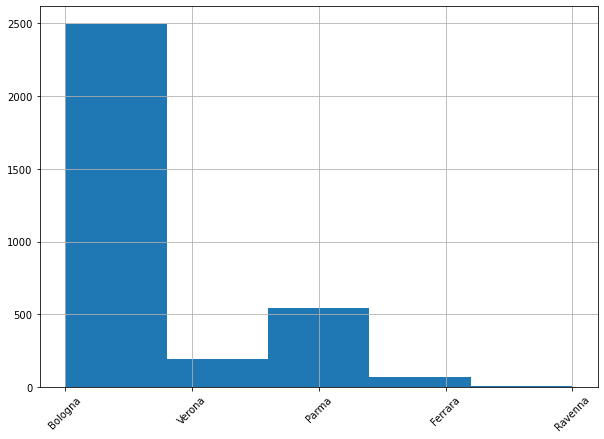

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

subset_max['AuthorDeathCity'].hist(bins=subset_max['AuthorDeathCity'].nunique())
plt.xticks(rotation = 45)
plt.xlabel("")
plt.show()

In [20]:
#for i in tqdm(range(2593+98, subset_max.shape[0])):
#    urlretrieve(subset_max['ImageURL'][i], '/scratch/students/schaerf/subset/'+subset_max['uid'][i]+'.jpg')

In [14]:
list_downloaded = [file.split('/')[-1].split('.')[0] for file in glob('/scratch/students/schaerf/subset/*')]
list_downloaded[0]

'383d8fb371ae4aa9bd3819fb973f0ac9'

In [15]:
morpho_graph_complete = []
metadata = []

## Testing similarity metrics

In [22]:
# efficientnet_b7 = models.efficientnet_b7(pretrained=True, progress=False)

# # remove last fully-connected layer
# new_classifier = nn.Sequential(*list(efficientnet_b7.classifier.children())[:-4])
# efficientnet_b7.classifier = new_classifier

In [16]:
uniques = subset_max[subset_max['uid'].isin(list_downloaded)].groupby('uid').first().reset_index()
print(uniques.shape)

(3301, 38)


In [19]:
# dict2emb = {}

# for i in tqdm(uniques.iterrows()):
#     dict2emb[i[1]['uid']] = sparse.csr_matrix(get_embedding(preprocess_image('/scratch/students/schaerf/subset/' + i[1]['uid'] + '.jpg'), efficientnet_b7)[:, 0])

# uniques_pos = positives.groupby('uid').first().reset_index()
# print(uniques_pos.shape)

# for i in tqdm(uniques_pos.iterrows()):
#     dict2emb[i[1]['uid']] = sparse.csr_matrix(get_embedding(preprocess_image('/scratch/students/schaerf/' + i[1]['set'] + '/' + i[1]['uid'] + '.jpg'), efficientnet_b7)[:, 0])


In [ ]:
# with open(data_dir + 'dict2emb.pkl', 'wb') as outfile:
#     pickle.dump(dict2emb, outfile)

# with open(data_dir + 'dict2emb_original.pkl', 'wb') as outfile:
#     pickle.dump(dict2emb, outfile)

In [17]:
with open(data_dir + 'dict2emb_original.pkl', 'rb') as infile:
    dict2emb = pickle.load(infile)

dict2emb['002e45b803f24a1e9f8c6f3768912d7d']

<1x2560 sparse matrix of type '<class 'numpy.float32'>'
	with 2560 stored elements in Compressed Sparse Row format>

In [18]:
tree = make_tree(uniques, dict2emb)

reference image 63a6e94aa7ac468799ea45f0df3134a1


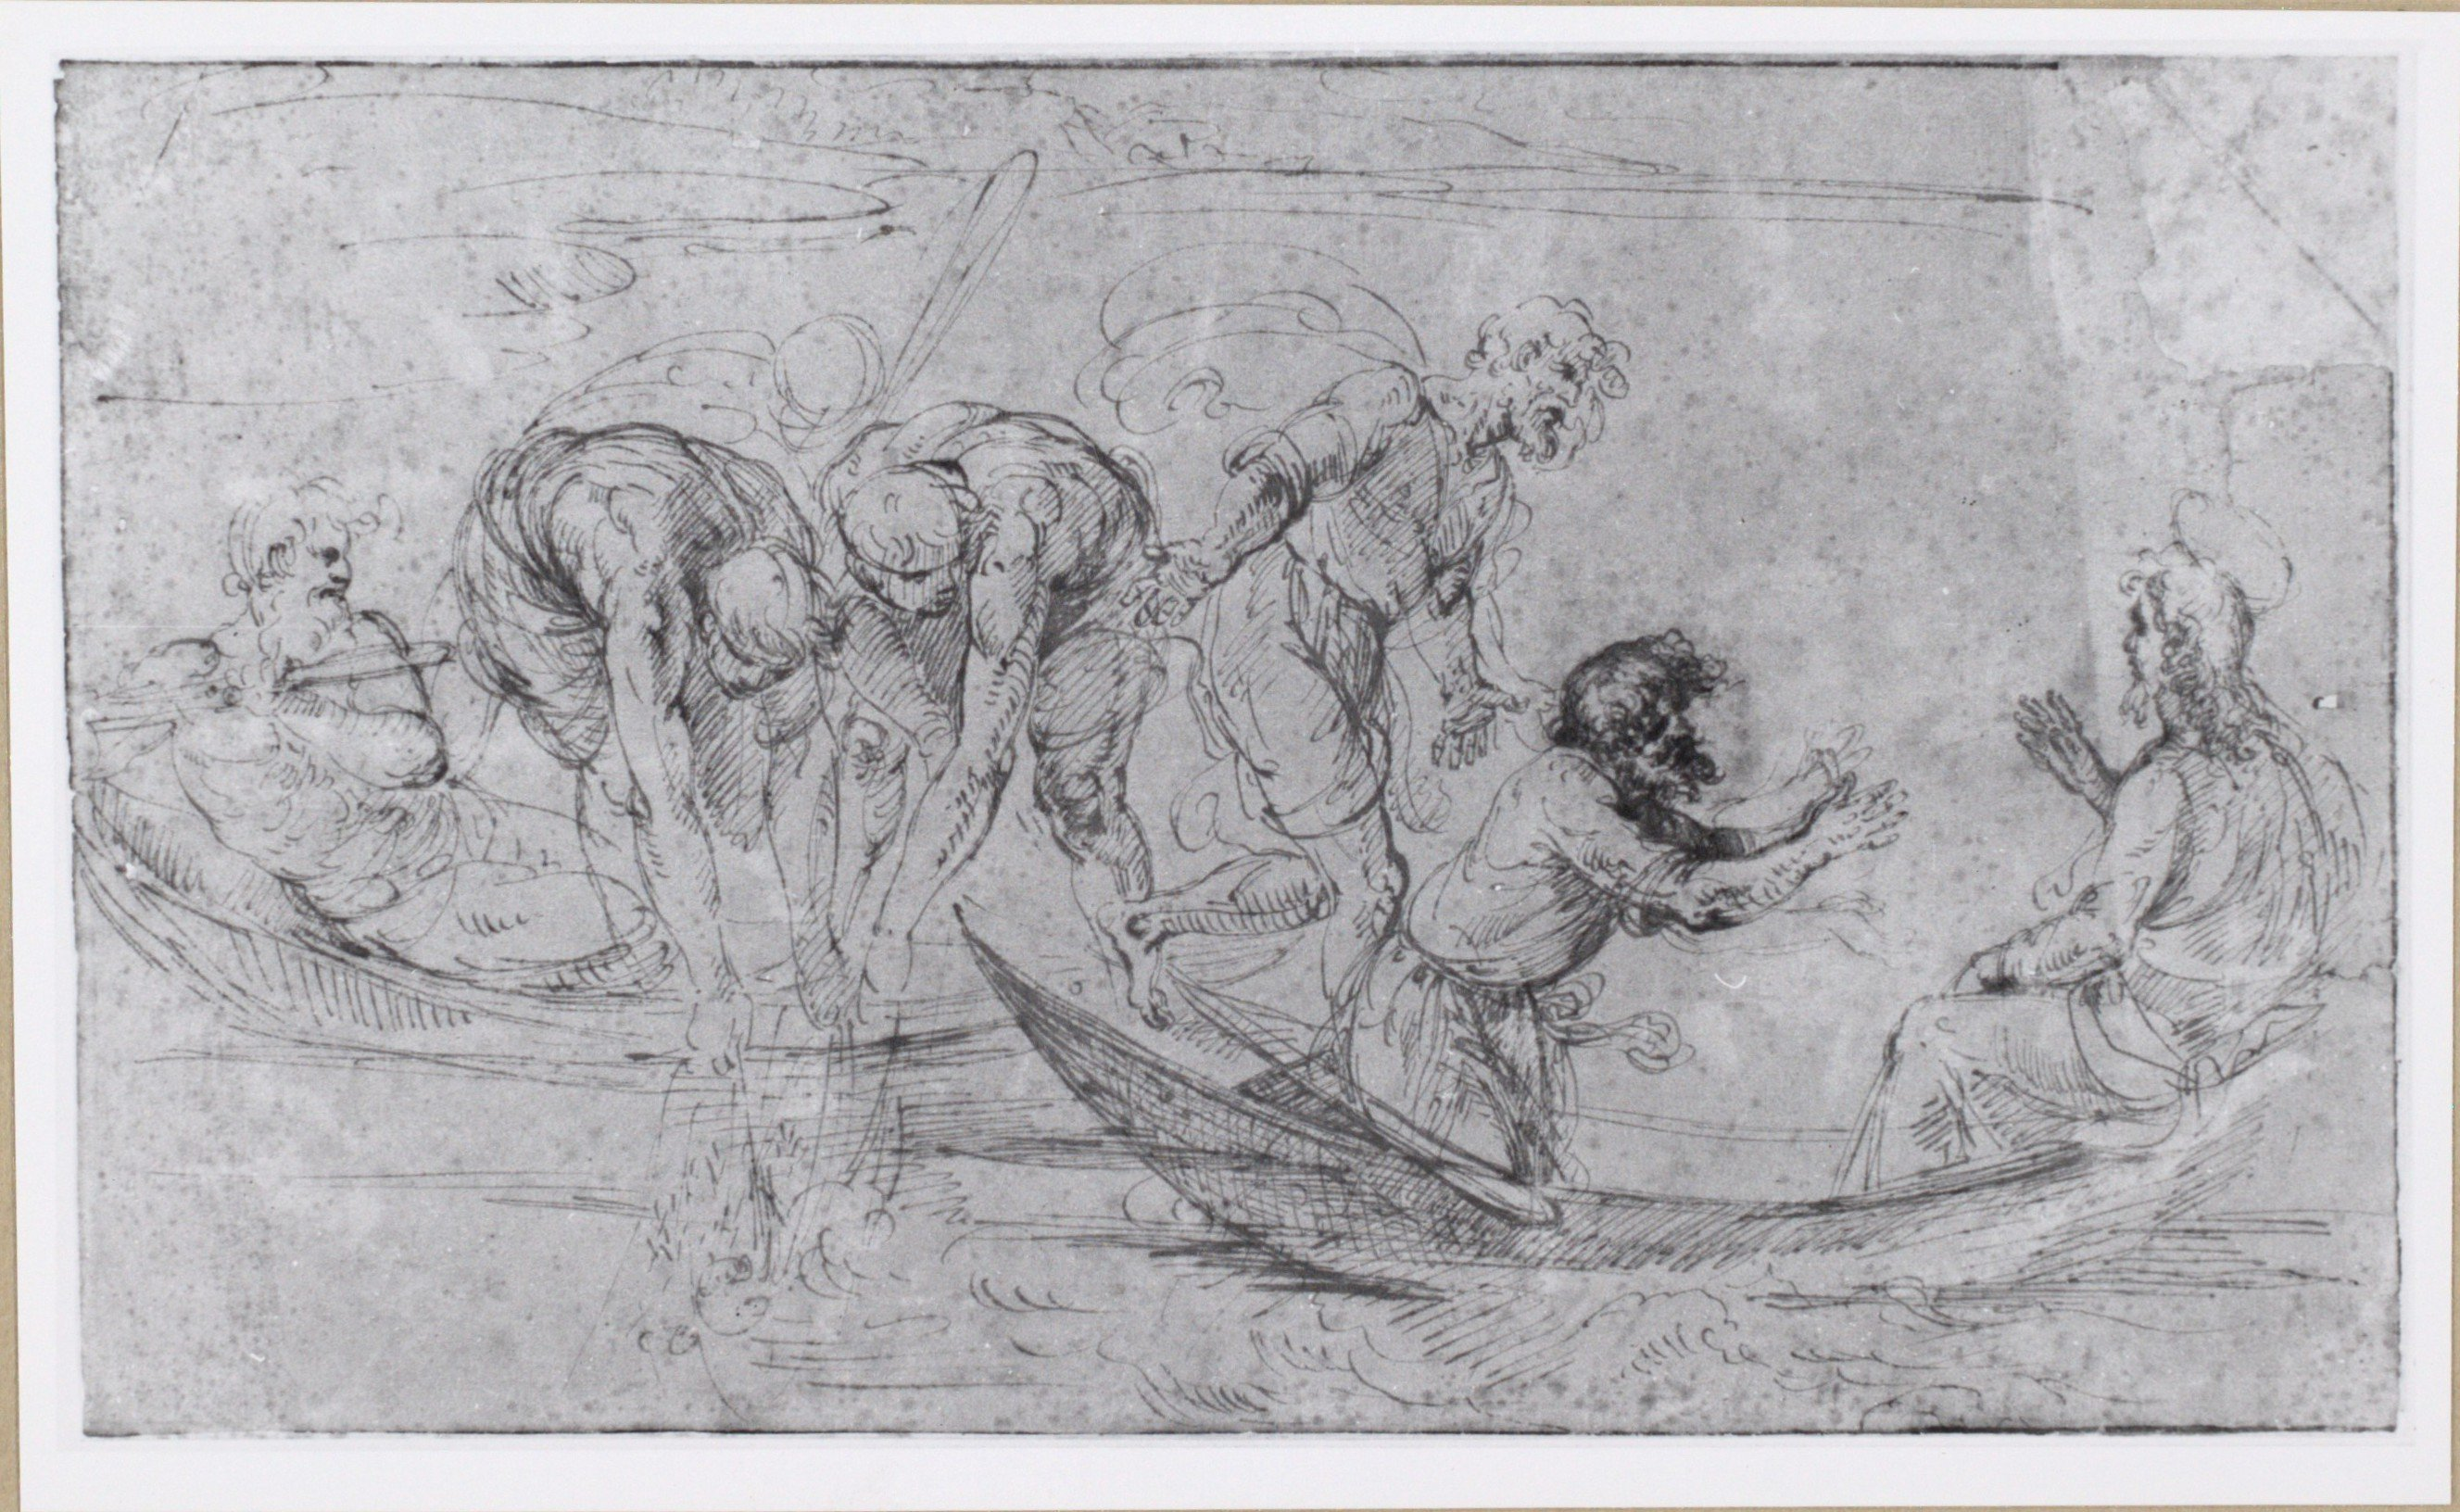

actual most similar image 66794131f9fc46999897c2584ea1cbf9


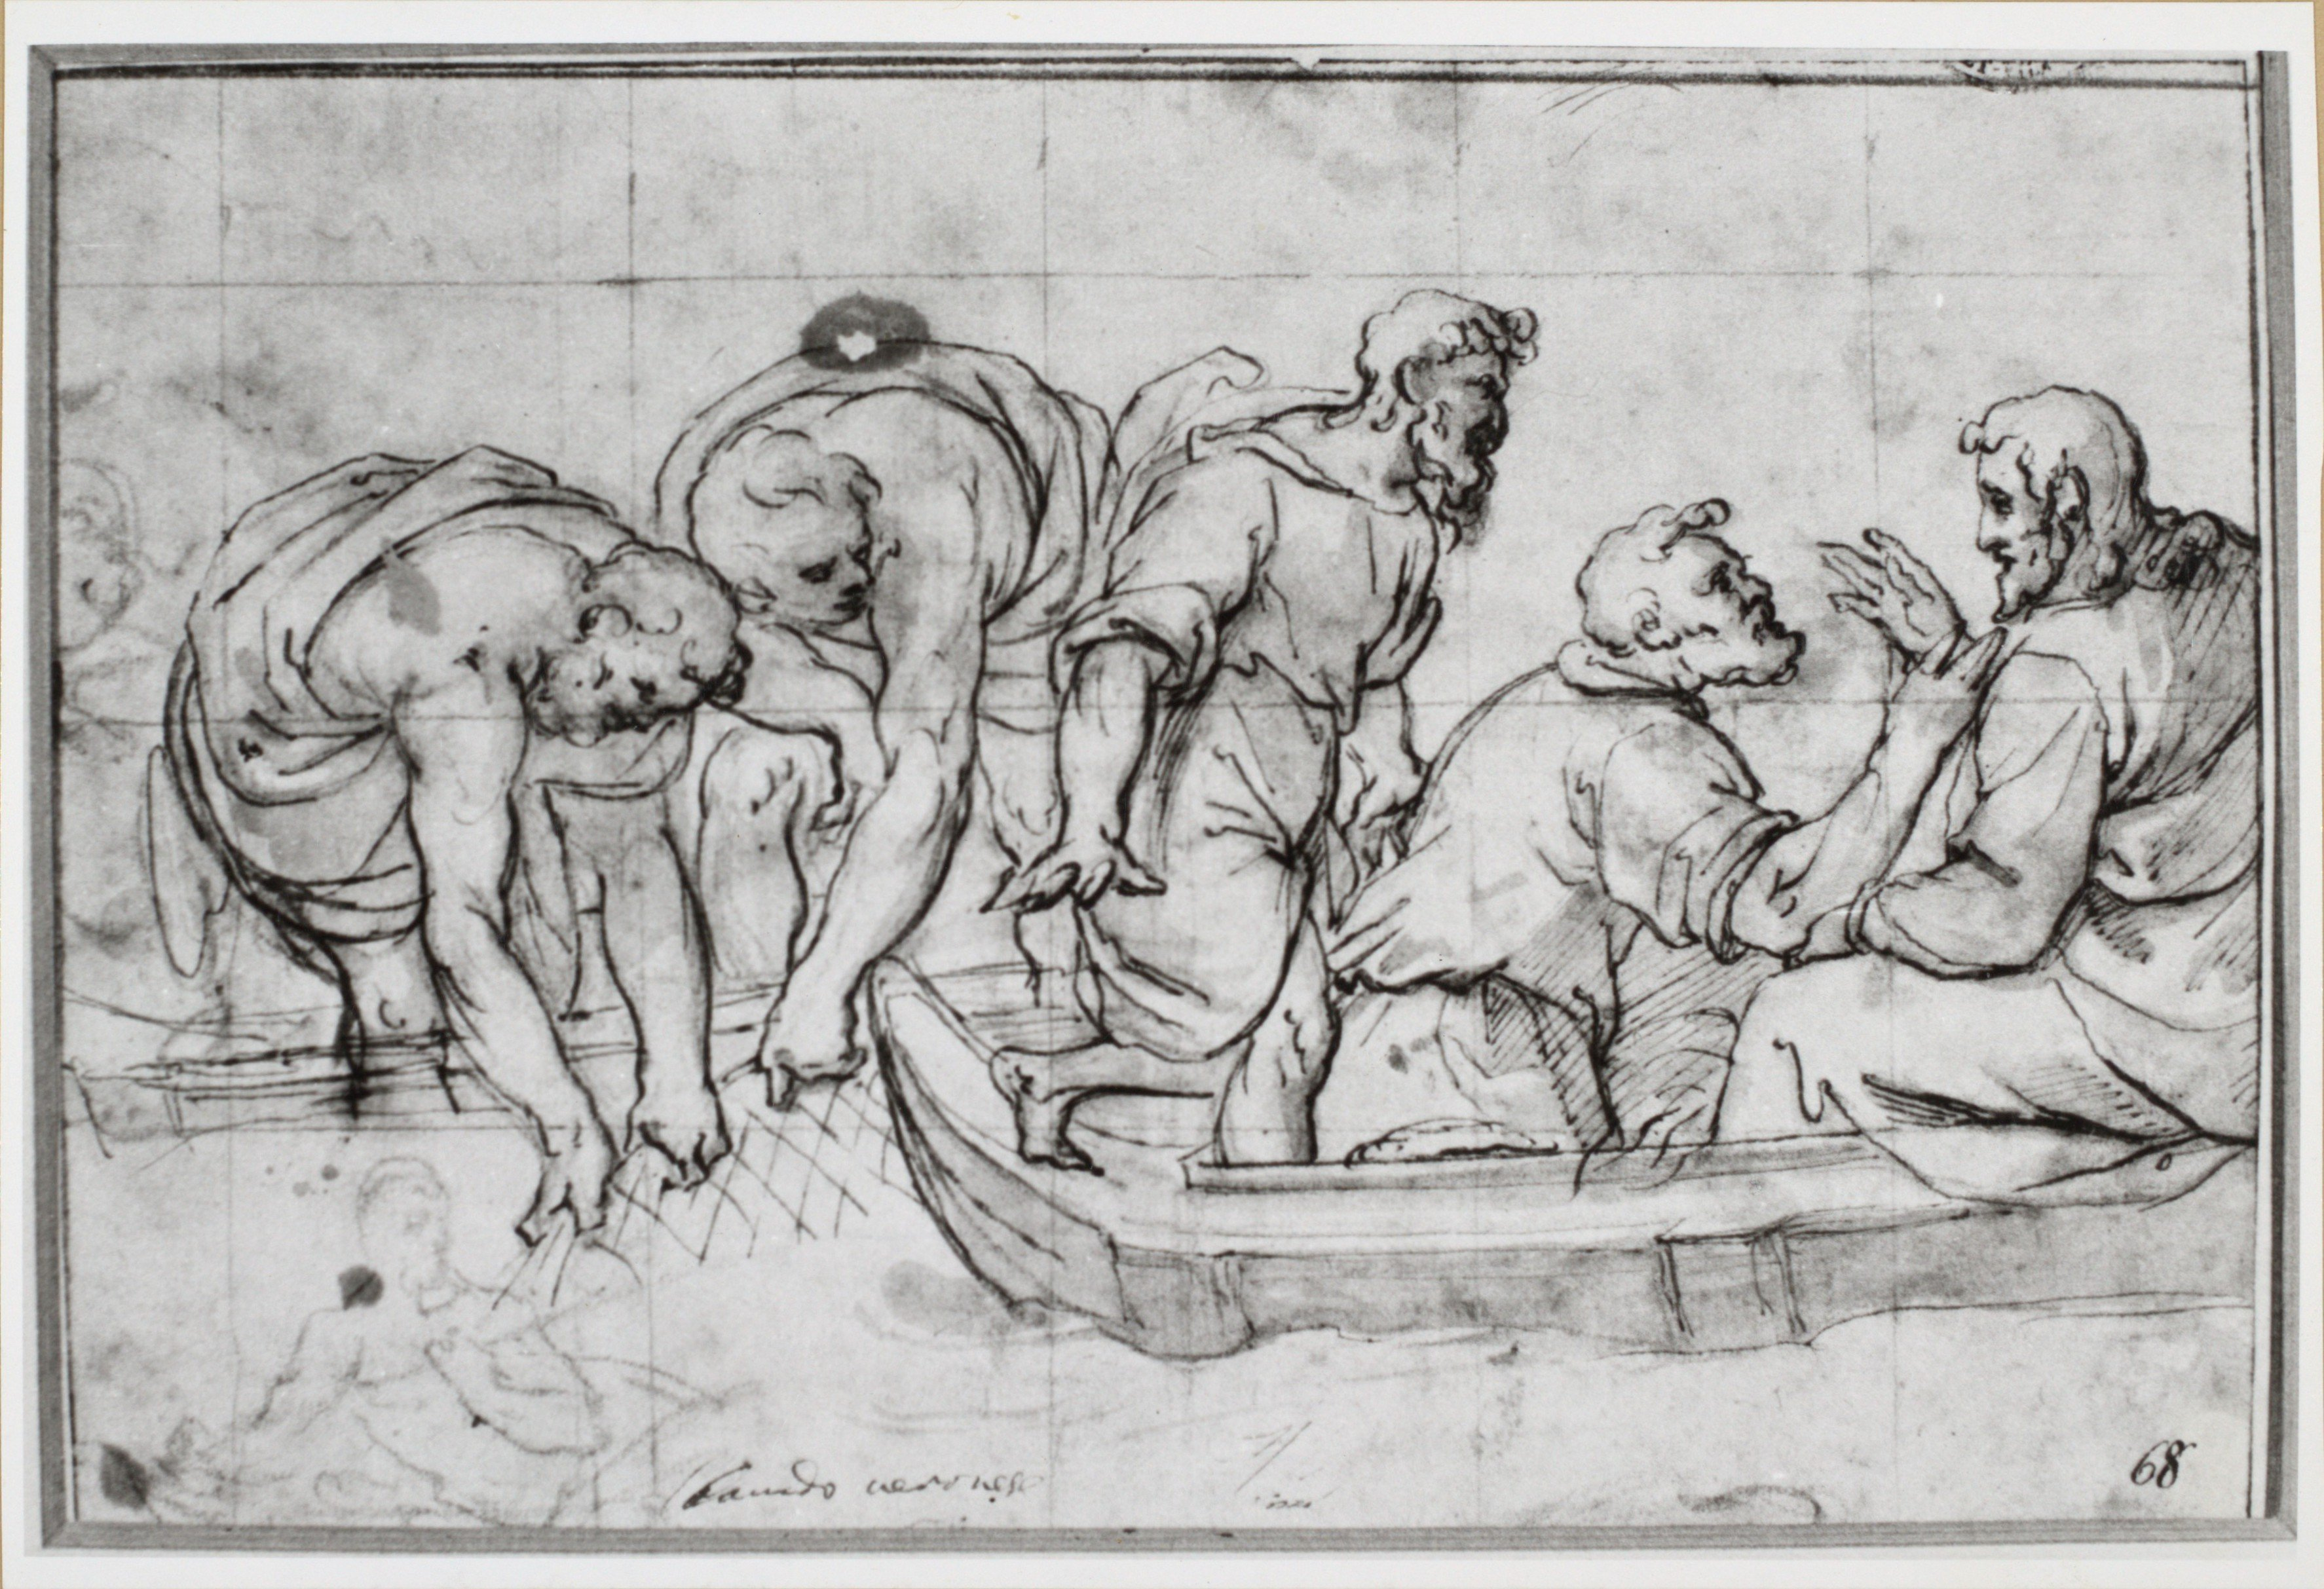

1 th most similar image according to model 07db18aac53c475d8e2ff300a198d7f0


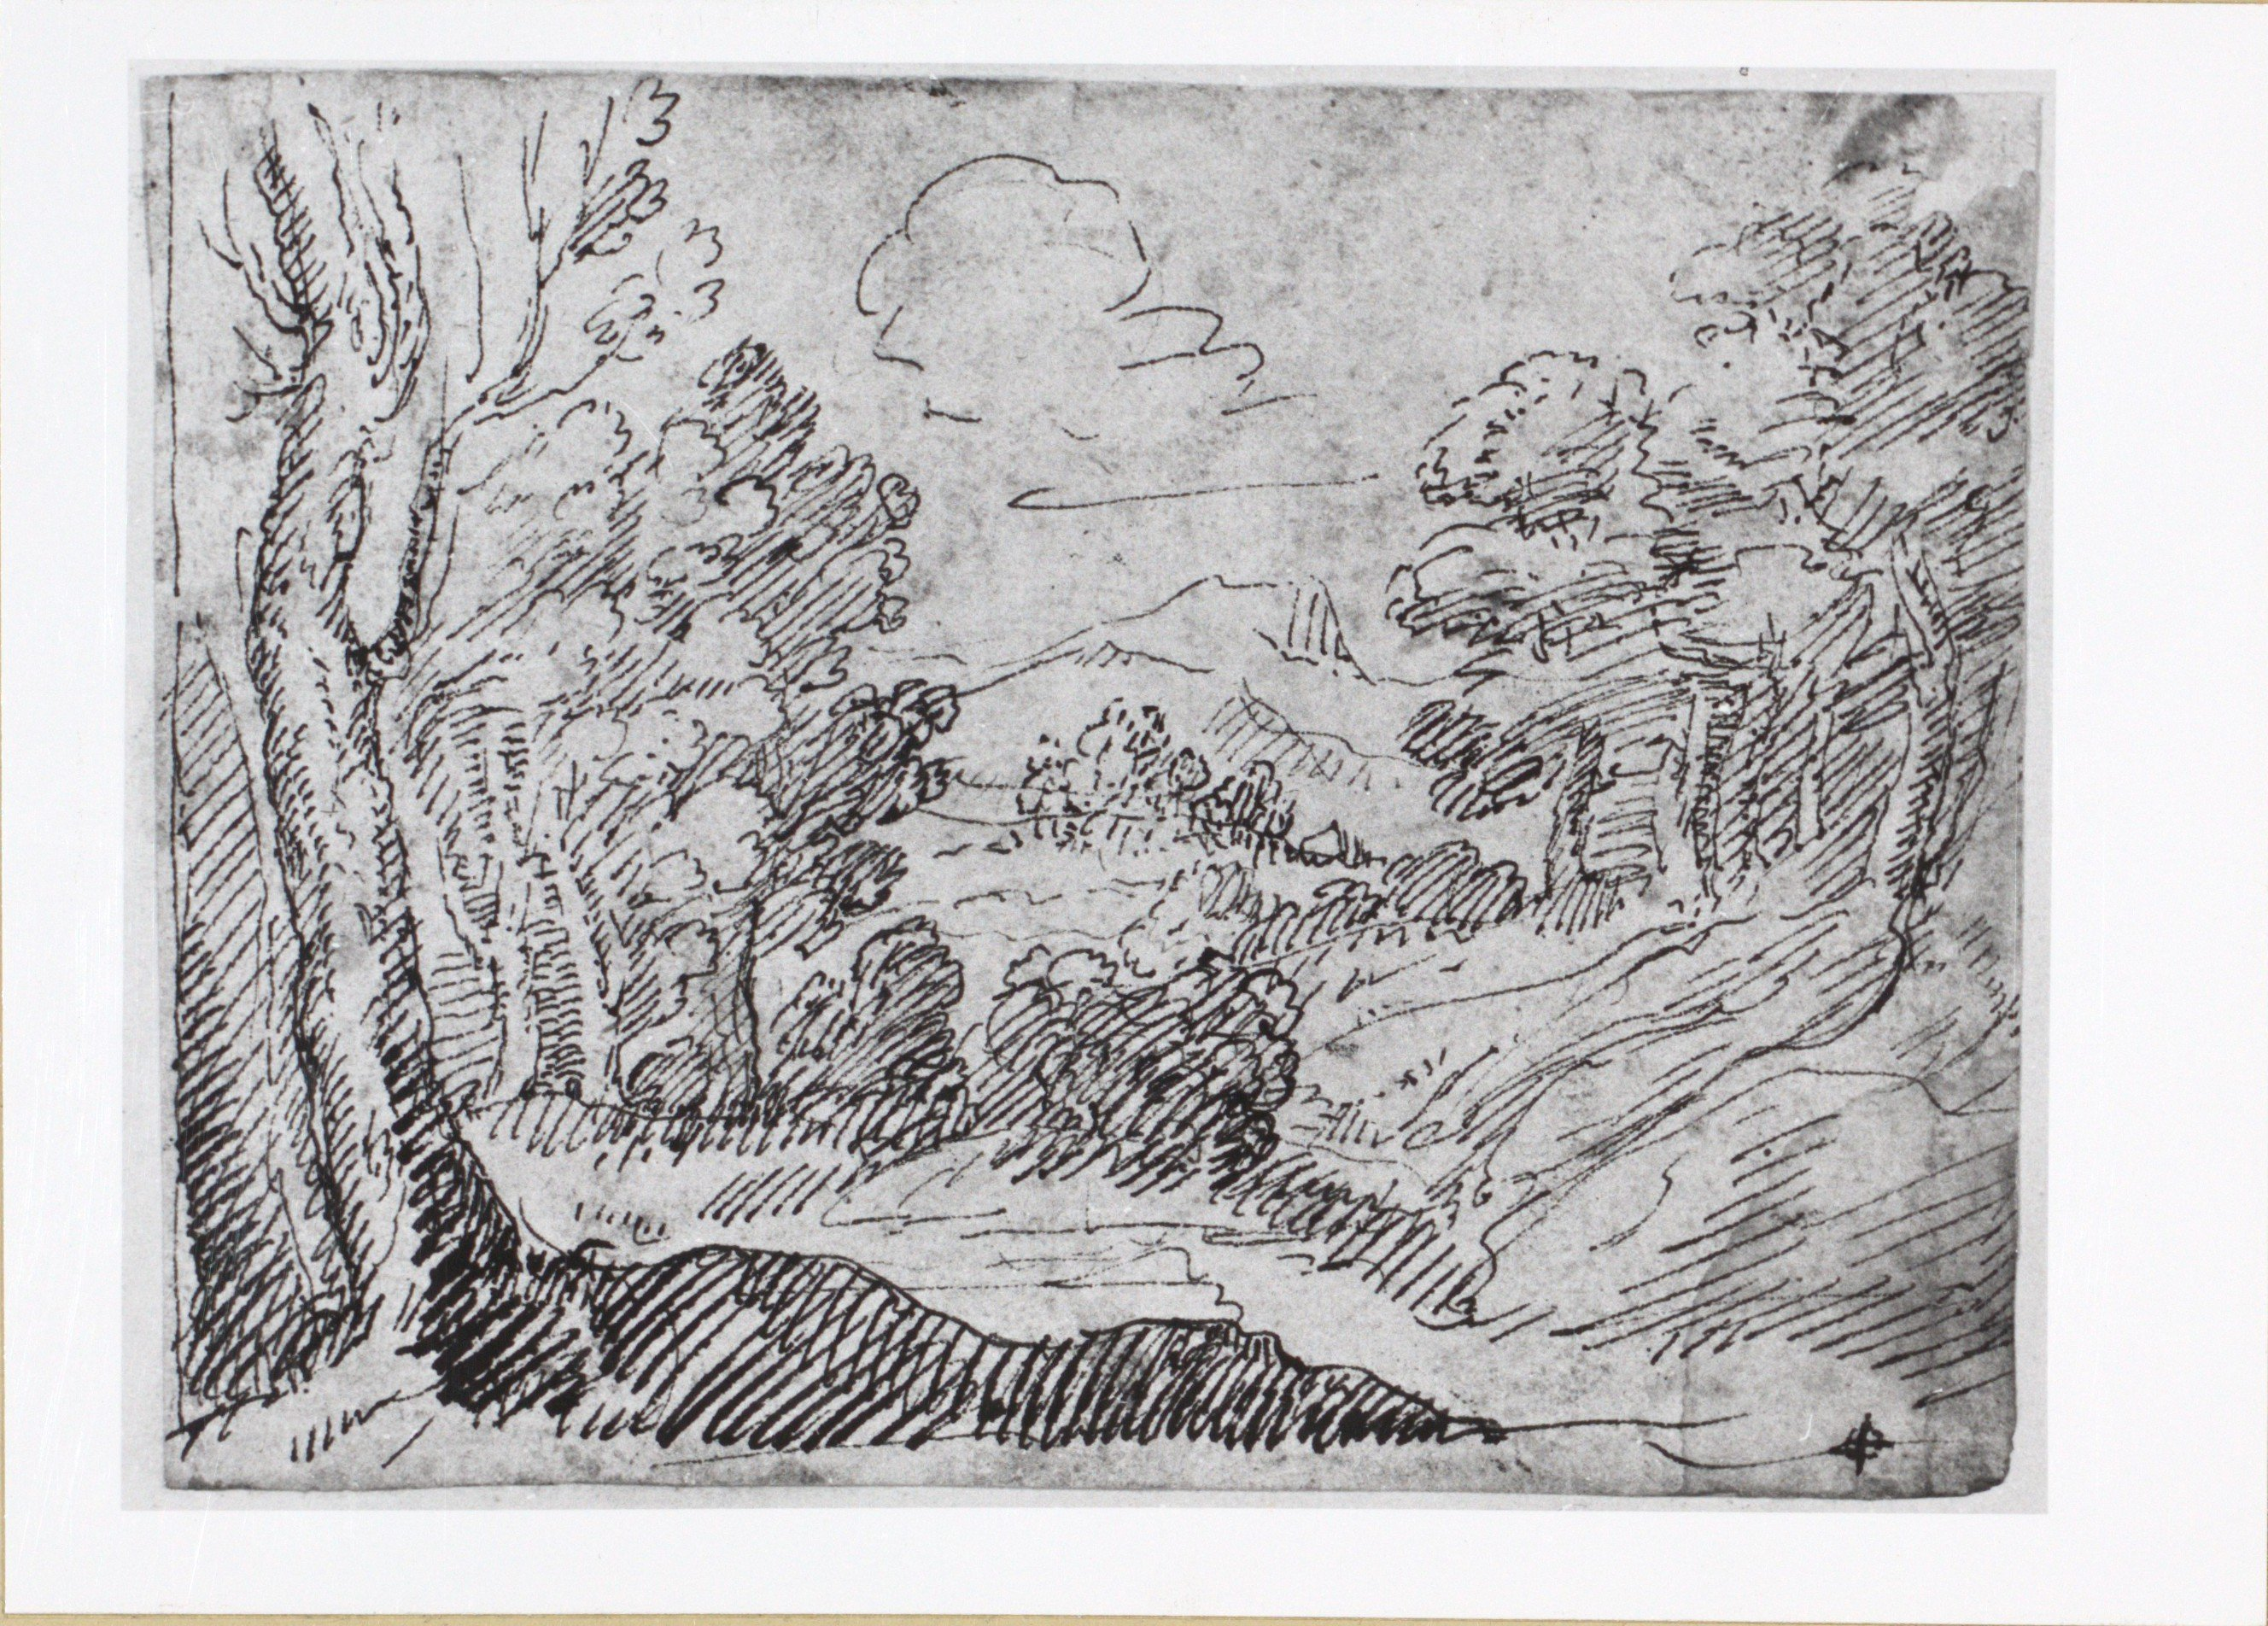

In [20]:
show_most_similar(positives.sample(), uniques, tree, dict2emb, n=1)

In [21]:
positives[positives['set'] == 'train'].reset_index().to_csv(data_dir + 'train.csv')
positives[positives['set'] == 'test'].reset_index().to_csv(data_dir + 'test.csv')
subset = pd.concat([uniques, positives[positives['set'] == 'test']], axis=0).groupby('uid').first().reset_index()
print(subset.shape)
subset.to_csv(data_dir + 'subset.csv')

(3713, 45)


In [22]:
uids_test = set(list(positives[positives['set'] == 'test']['uid']))
uids_subset = set(list_downloaded)

print(len(uids_test.intersection(uids_subset)))

429


### Model

According to Seguin (2016), the model to find similar images is obtained using the loss:

l(A,B,C) --> l(A,B) < l(B,C)

where A is the input image, B is the morphograph ground truth, C is an image that is considered similar by a pre-trained model.

So the steps are:

Model 1: e.g. any well performing model from https://pytorch.org/vision/stable/models.html, give all images in the data and obtain embedding (i.e. last CNN layer) of all of them. Compute most similar embeddings to the embeddings of the images in the morphograph.

Model 2: fine tune the model with the loss above. The model should stop at the embedding layer.


However, since the parameters of the similarity function s are updated
during the training process, so does the set of hard triplets. Thus, we need to iteratively mine
hard-triplets, and optimize the function s, as shown by the following pseudo-code:
Require: Initial similarity function s, collection C , morphograph G
1: for n = 1..Number of training epochs do
2: index ← BUILDSEARCHINDEX(C , s)
3:Ai ,Bi ,Ci 	← SAMPLEHARDTRIPLETS(G,index)
4: s← OPTIMIZESIMILARITYFUNCTION(s,  Ai ,Bi ,Ci i )
5: end for

#### Is the loss and training defined somewhere?

page 109 of pdf:

Δi = s(Ai, Bi) − s(Ai,Ci) > 0

Hinge Loss : 

lm(Δi) = max(0, m−Δi)

Final loss:

L = sumi lm(Δi )

#### Can we improve this? i.e. another loss, more finetuning layers on artworks?


https://neptune.ai/blog/pytorch-loss-functions 


In [23]:
train = pd.read_csv(data_dir + 'train.csv')
items = set(train['img1'])
items_2 = set([it.split('/')[-1].split('.')[0] for it in glob(data_dir + 'train/*.jpg')])
print(len(items.difference(items_2)))

0


In [24]:
dts = {x: ReplicaDataset(data_dir + x + '.csv', data_dir + 'dict2emb.pkl', data_dir + 'subset.csv', data_dir, x) for x in ['train', 'test']}

In [25]:
train_dataloaders = {x: DataLoader(dts[x], batch_size=8, shuffle=True) for x in ['train', 'test']}
train_a, train_b, train_c = next(iter(train_dataloaders['train']))
print(f"Feature batch shape: {train_a.size()}")

Feature batch shape: torch.Size([8, 1, 3, 224, 224])


In [26]:
dataset_sizes = {x: len(dts[x]) for x in ['train', 'test']}
dataset_sizes

{'train': 805, 'test': 429}

In [27]:
from model_replica import ReplicaNet
model = ReplicaNet(device='cuda')

In [28]:
# train_replica(model, train_dataloaders, dataset_sizes, dts, num_epochs=2)

In [29]:
model.load_state_dict(torch.load(data_dir + 'model_weights'))

<All keys matched successfully>

In [ ]:
# a, b, c = dts['train'].__getitem__(70)
# A, B, C = model.forward(train_a.squeeze(1).to('cuda'), train_b.squeeze(1).to('cuda'), train_c.squeeze(1).to('cuda'))

In [33]:
with open(data_dir + 'dict2emb.pkl', 'rb') as infile:
    dict2emb = pickle.load(infile)

list(dict2emb.values())[0].shape

(1, 2560)

In [35]:
for i in tqdm(range(uniques.shape[0])):
    uid, A = dts['train'].__get_simgle_item__(i)
    A = A.squeeze(1).to('cuda')
    dict2emb[uid] = model.predict(A)

100%|██████████| 3301/3301 [10:57<00:00,  5.02it/s]


In [39]:
with open(data_dir + 'dict2emb.pkl', 'wb') as outfile:
    pickle.dump(dict2emb, outfile)

reference image be8dafdf1fb340a990b6ff2e5b97d116


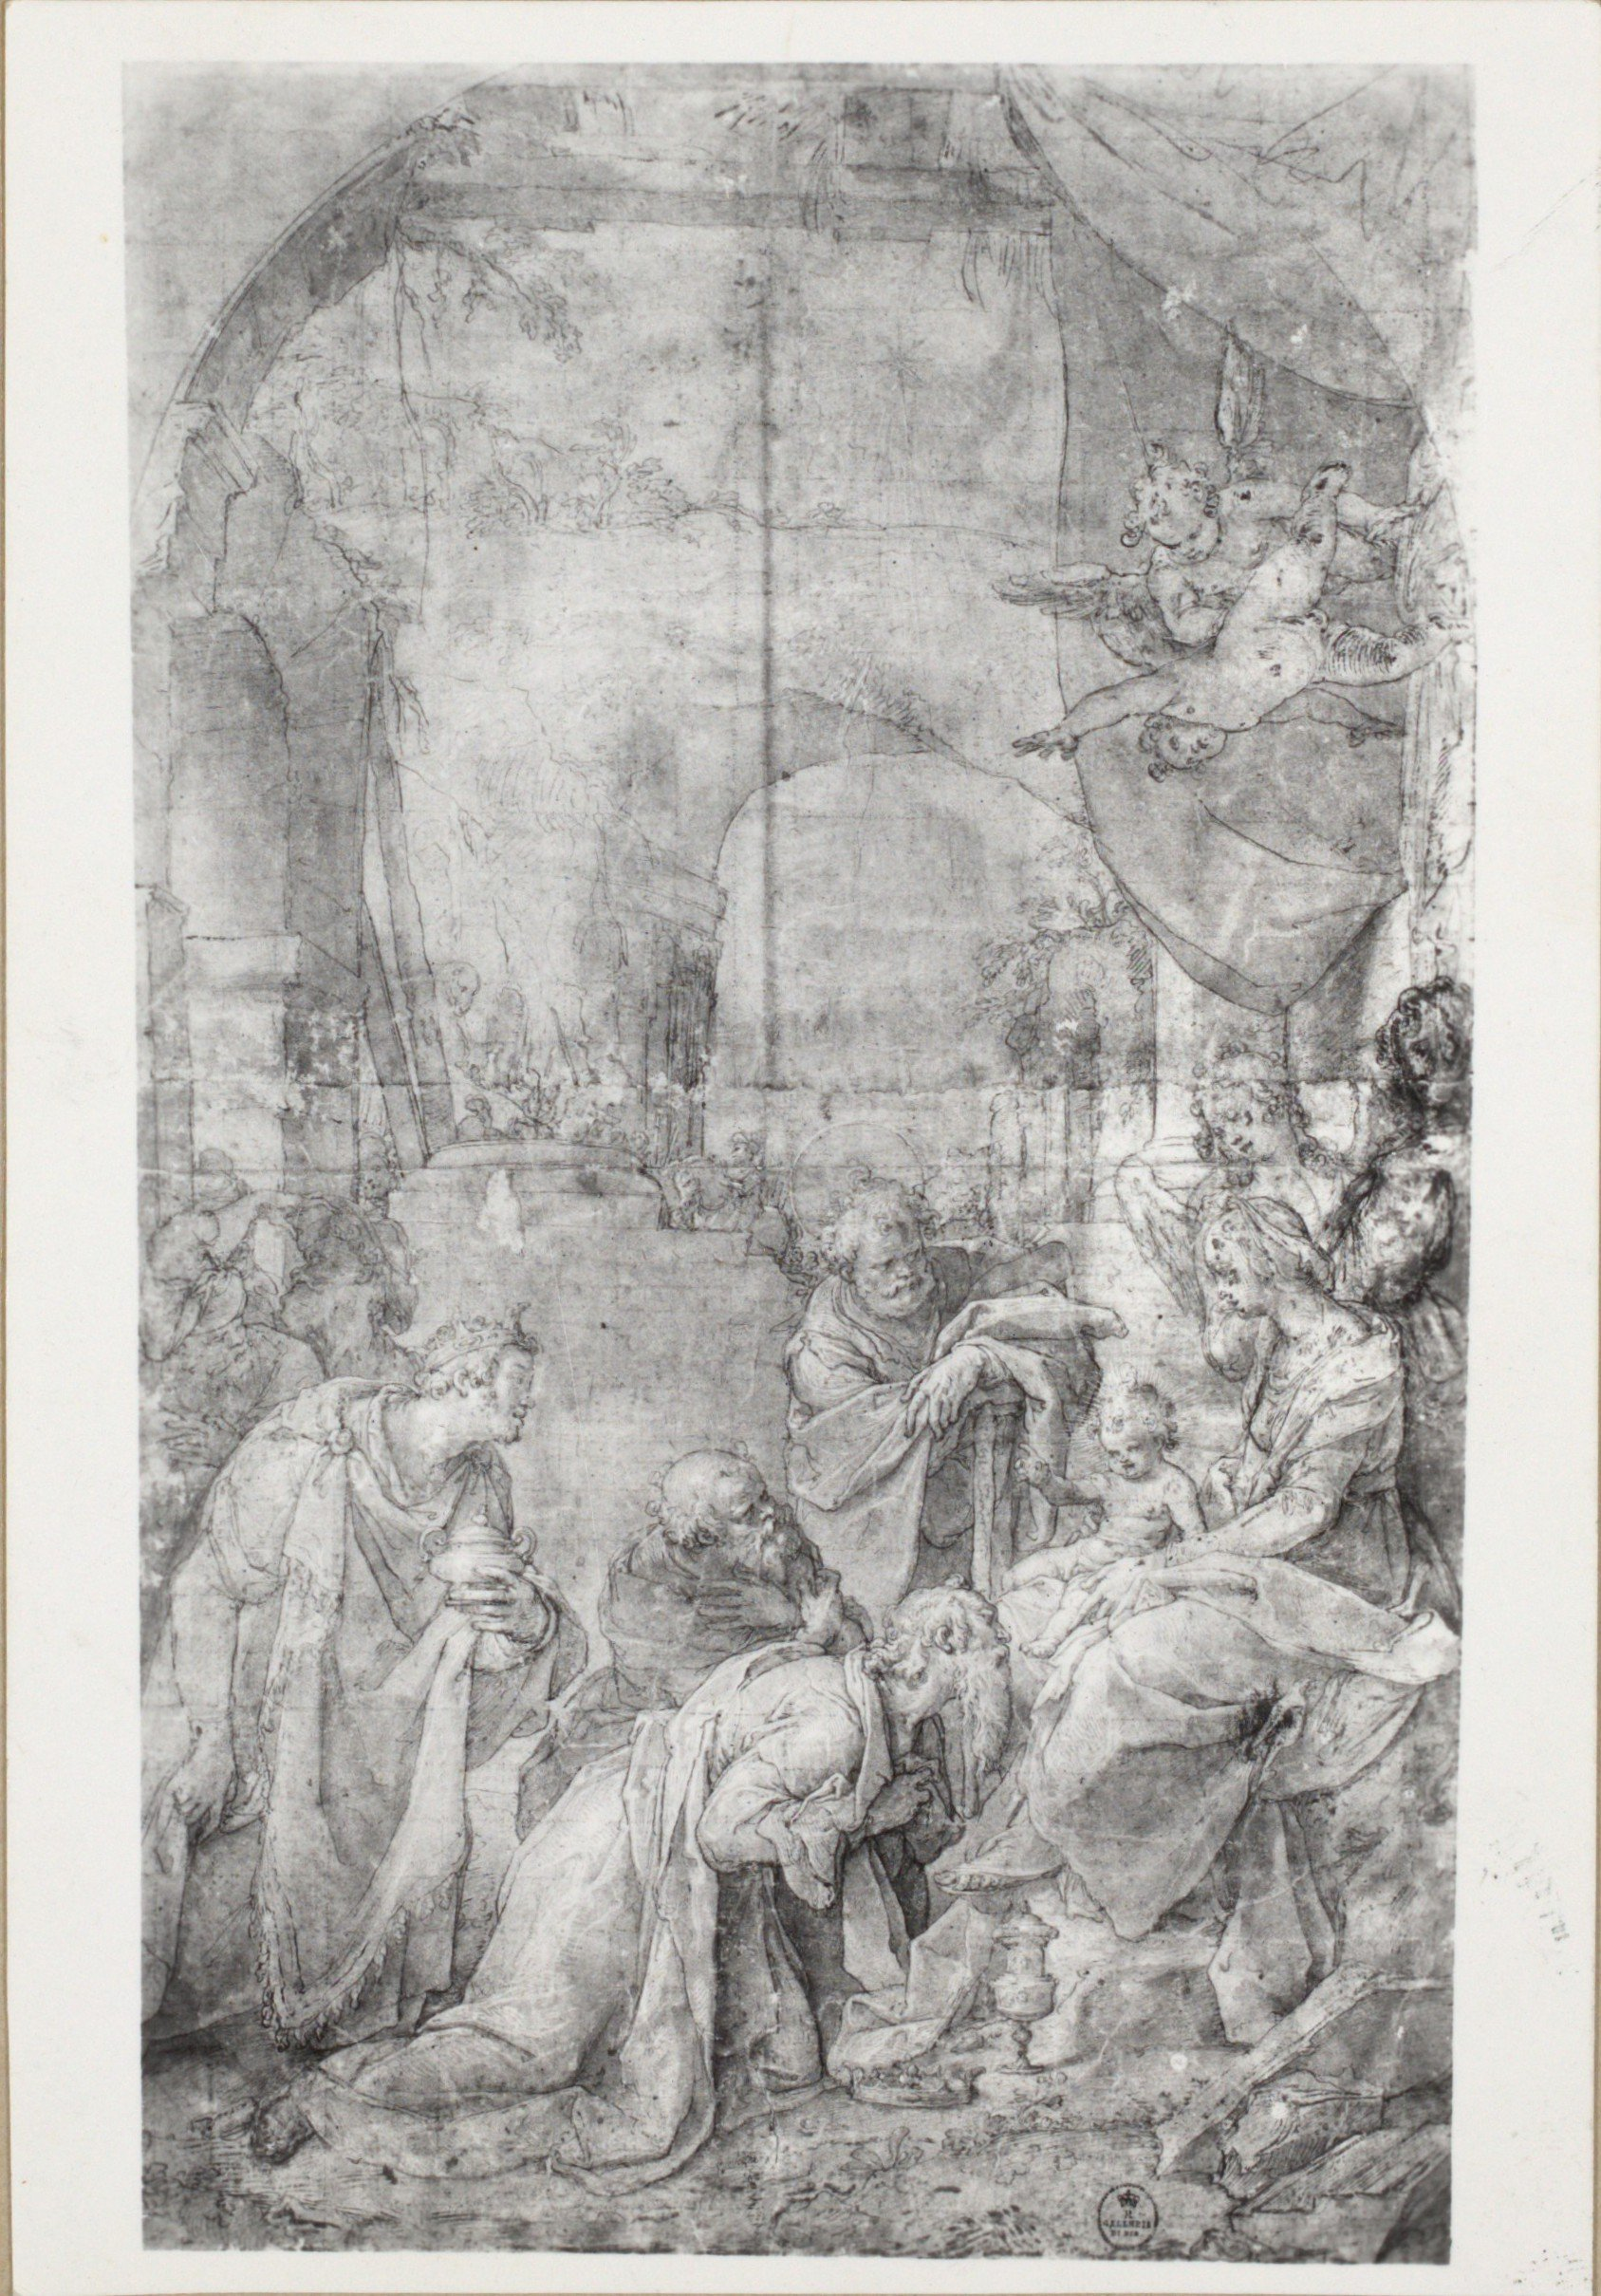

actual most similar image 84e824a0405e4ade9f463203309a05d6


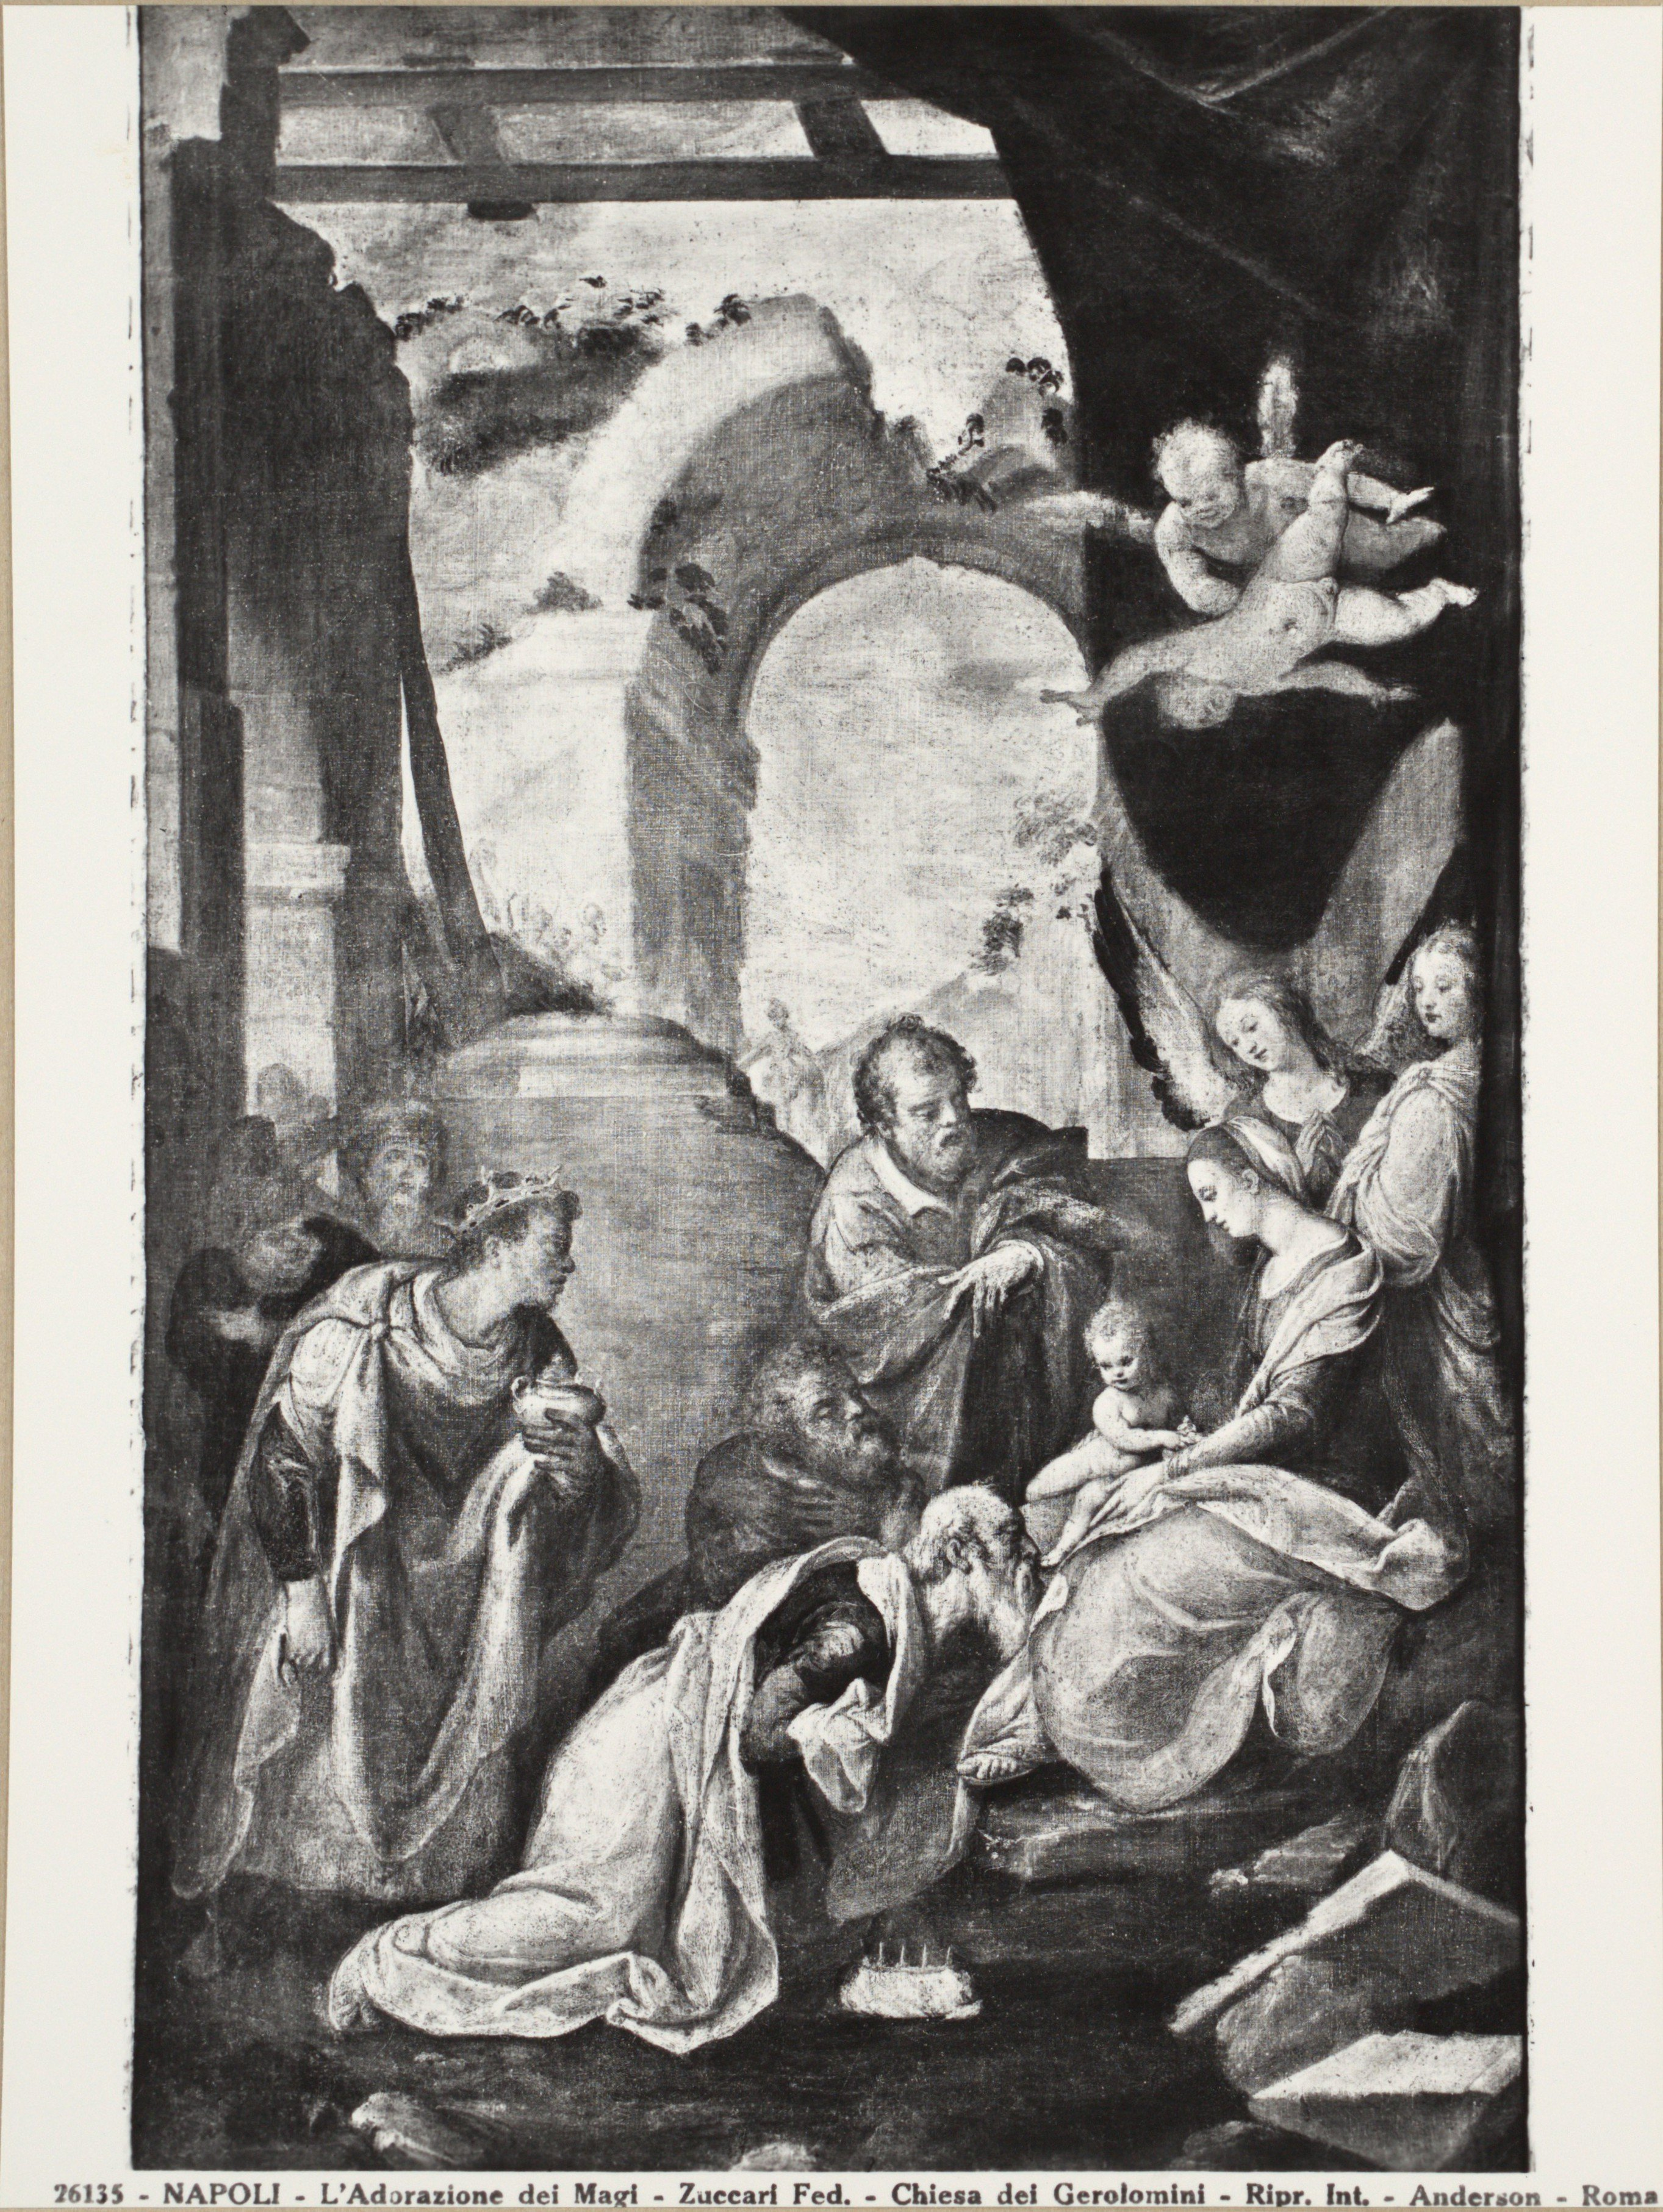

1 th most similar image according to model fc31271e77fb4d49a6f981eff25859b1


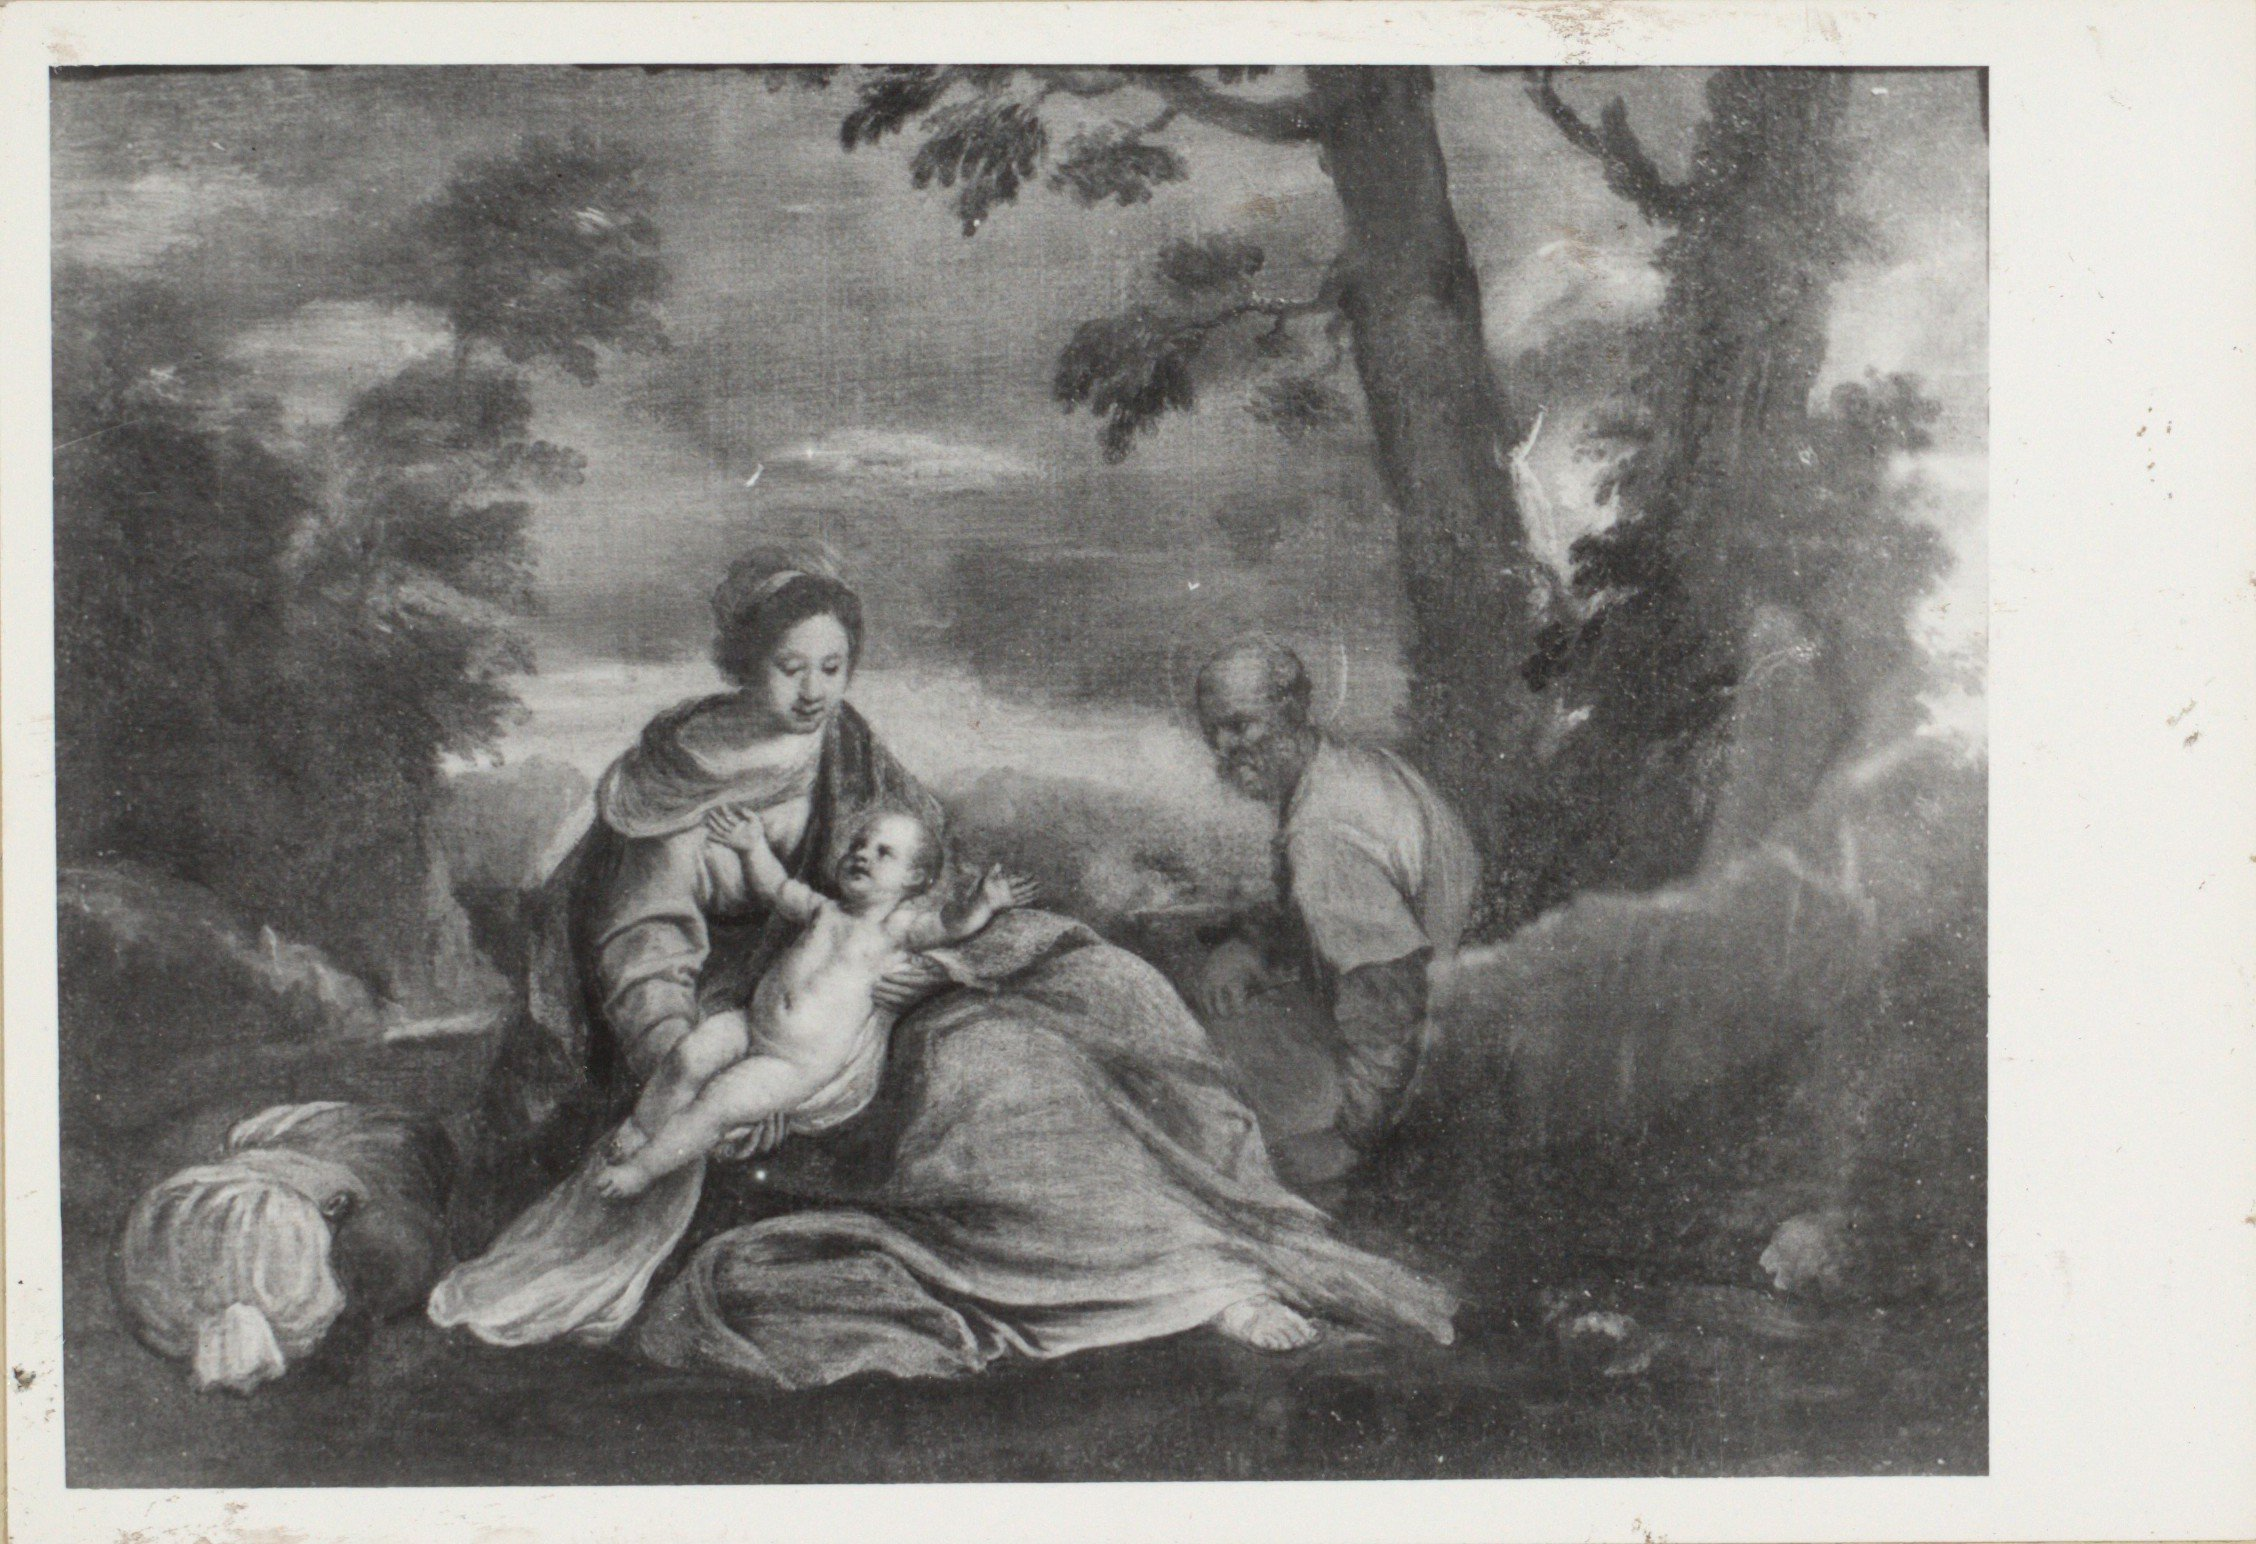

In [38]:
tree = make_tree(uniques, dict2emb)
show_most_similar(positives.sample(), uniques, tree, dict2emb, n=1)

Store final weights of the finetuned model for prediction.

Evaluation:
- metrics introduced by Seguin (2016), in replica_search.train_retrieval

### Topological Data Analysis

Since we wish to map the space of images so that the similar ones are close in space and that we can show a structure of such similarities, we use the **mapper** algorithm to find such structure and substructures.

Input: the embeddings of the images
TDA
Output: skeleton of the space, clusters

Evaluation: use the clusters and the closeness of the clusters in the skeleton to evaluate the structure.
Based on: morphohraph, predictions of the model based on different inputs.

In [ ]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/guhennec/scratch/2021_Cini/TopologicalAnalysis_Cini/scripts')

#from Mapper_Tools_Repl import MapperGraph
import kmapper as km

mat_cini = np.load(path + 'Replica_UIDs_ResNet_VGG_All.npy', allow_pickle=True)
mat_cini.shape


(329480, 3)

### Visualize the results

Using Flask, improve the visualization of the results.

### More:

#### Can we compare the process to a similar process on the metadata?
#### Do the clusters / structure of clusters mirror what we already know?